# Background

K means clustering is an unsupervised learning method. The goal is to assign data points to groups such that all points in the same group are as similar as possible and that points in different groups are as dissimilar as possible.

# Learning aims

* Basics of k-means functionality
* Variations within its implementation
* Advantages and limitations
* Practice writing some code!

In [1]:
#import libraries and set up notebook

import numpy as np
rng = np.random.default_rng()

import pandas as pd

from matplotlib import pyplot as plt

import seaborn as sns
sns.set_style("dark")
sns.set_palette("bright")

from sklearn.datasets import make_blobs

# Creating datasets

Initially I developed my algorithm using randomly generated uniform clouds of data points. Later I started using data sets comprising multiple clusters of points. This meant I was able to get a more realistic understanding of algorithms effectiveness.

In [2]:
#create a dataframe containing a uniformly random spread of points
#takes min and max of range from which to select values, and resulting array size
#returns a dataframe with array values held in 2 cols labelled x and y
def uniform_df(int_floor, int_ceil, array_size):
    return pd.DataFrame(np.random.randint(int_floor, int_ceil, size=array_size), columns=['x','y'])

df_uniform = uniform_df(0, 100, (300, 2))
df_uniform.head()

,x,y
0,25,76
1,44,54
2,89,2
3,80,62
4,72,2


In [3]:
#create a dataframe containing points clustered around a defined number of centres
#takes number of points to create and number of clusters to create
#returns a dataframe with array values held in 2 cols labelled x and y
def clusters_df(n_samples, centers,
                n_features = 2): #model only defined for 2 dimensions

    #max_iter = 10 #what does this do?
    
    X, y = make_blobs(n_samples=n_samples, 
                      n_features=n_features, 
                      centers=centers,)
                      #random_state=random_state)
    
    return pd.DataFrame(X, columns=['x','y'])

df_clusters = clusters_df(200, 3)
df_clusters.head()

,x,y
0,-9.310240,3.411113
1,3.326800,8.280665
2,-9.070192,2.310086
3,-4.380260,3.995568
4,2.526901,8.027362


# Helper functions

A couple of functions to help with iterative process of identifying centroid positions for a given initialisation.

In [4]:
#takes a row from 2 dataframes, both with coordinates stored in cols labelled x and y
#returns euclidean square distance between the points represented by the two rows
def squared_distance(points_row, centroid_row):
    squ_distance = (points_row['x'] - centroid_row['x'])**2 + (points_row['y'] - centroid_row['y'])**2
    return squ_distance

In [5]:
#takes points dataframe and current centroid dataframe
#returns updated points dataframe with each point reassigned to its closest centroid
def assign_points_to_nearest_centroid(df, df_c):
        
    #create new distances dataframe
    #for each centroid:
    #calculate distance from centroid to each point
    #new dataframe has col per point and row per centroid
    df_d = df_c.apply(lambda df_c_row: df.apply(lambda df_row: squared_distance(df_row,df_c_row), axis=1), axis=1)      
    
    #assign each point to its nearest centroid
    #for each point (col), return index of row with minimum value (closest distance), as centroid selection
    df['centroid'] = df_d.idxmin(axis=0)
    
    return df

In [6]:
#takes points dataframe with updated centroid assignment
#returns new calculated centroid positions as means of assigned points
def calculate_centroid_positions(df):
    
    #create centroid dataframe as mean of points assigned
    df_c = df.groupby(['centroid']).mean()
    
    #format centroid dataframe
    df_c = df_c.reset_index()
    df_c = df_c[['x', 'y', 'centroid']]    
    
    return df_c

# Centroid initialisation methods
* Forgy
* Random partition

These 2 centroid initialisation methods seem to be the most widely used.

In [7]:
#forgy centroid initialisation randomly selects k points to be the centroids
#returns a dataframe containing row for each centroid, cols: x value, y value, centroid no.
#does not alter data points dataframe
def initialise_centroids_forgy(df, k):
    
    #take k sized sample of df for centroids
    df_c = df.sample(k)        
    df_c = df_c.reset_index(drop=True)    
    df_c['centroid']=df_c.index
    
    #update points dataframe by assigning each point to its nearest centroid
    df = assign_points_to_nearest_centroid(df, df_c)
    
    return df_c

df = clusters_df(200, 3)
k = 3
df_c = initialise_centroids_forgy(df, k)
df_c.head()

,x,y,centroid
0,6.850349,-2.051048,0
1,7.694069,-1.424180,1
2,-3.982145,-9.884419,2


In [8]:
#random partition centroid initialisation randomly assigns each point to a centroid and calculates the resulting centroid location
#returns a dataframe containing row for each centroid, cols: x value, y value, centroid no.
#points dataframe is updated to indicate centroid assignment for points
def initialise_centroids_random_partition(df, k):
    
    #create series of random centroid numbers, length of points dataframe
    centroid_series = pd.Series(rng.choice(k, df.shape[0]))
    
    #check we have created k centroids; all centroids must have at least 1 point assigned to them
    #if not then create new random series until that is the case
    while centroid_series.nunique() != k:        
        centroid_series = pd.Series(rng.choice(k, df.shape[0]))    
    
    #assign centroids to points
    df['centroid'] = centroid_series    
    
    return calculate_centroid_positions(df)

df = clusters_df(200, 3)
k = 3
df_c = initialise_centroids_random_partition(df, k)
df_c.head()

,x,y,centroid
0,-0.237247,1.748045,0
1,0.712279,2.211539,1
2,1.338389,3.106577,2


# Plotting helper functions

I implemented the plotting functions below to simplify the process of displaying my results. Some of the plots are more aimed at demonstrating functionality and the how the final result is obtained. There are several computational steps associated with creating the data for these plots which are not neccessarily required for the computation of the final result. To make the process more efficient these steps could be removed, but for my illustrative purposes they remain useful.

In [9]:
#takes points dataframe and centroid dataframe
#returns a scatterplot of points and centroids
def plot_df_and_df_c(df, df_c):
    
    #create label to indicate if a row refers to a centroid or a point
    df['is_centroid']=False
    df_c['is_centroid']=True
    
    #combine points and centroid dataframes
    df_combined = df.append(df_c, ignore_index = True)
    
    #force treatment of centroid no. col as categorical datatype as this improves colour contrast for plotting
    df_combined['centroid'] = df_combined['centroid'].astype('category')
    
    ax = sns.scatterplot(data=df_combined, x="x", y="y", hue='centroid', 
                     style='is_centroid', size='is_centroid', sizes=(100, 20), 
                     legend=False)
    ax.set_aspect('equal')
    
    return ax

Now we can visualise the characterisic differences between:
* Uniform and cluster datasets
* Forgy and random partition initialisations

## Uniform dataset
### Forgy centroid initialisation

<AxesSubplot:xlabel='x', ylabel='y'>

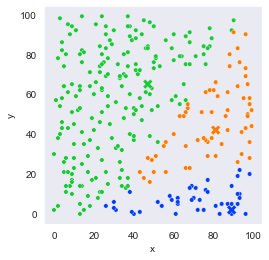

In [10]:
df = df_uniform
k = 3
df_c = initialise_centroids_forgy(df, k)

plot_df_and_df_c(df, df_c)

## Uniform dataset
### Random partition centroid initialisation

<AxesSubplot:xlabel='x', ylabel='y'>

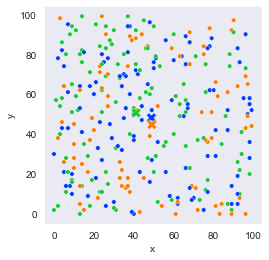

In [11]:
df = df_uniform
k = 3
df_c = initialise_centroids_random_partition(df, k)

plot_df_and_df_c(df, df_c)

## Clusters dataset
### Forgy centroid initialisation

<AxesSubplot:xlabel='x', ylabel='y'>

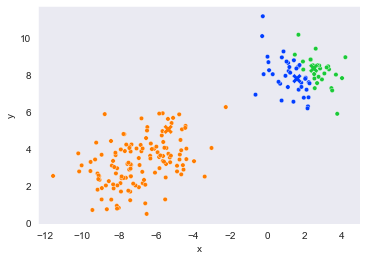

In [12]:
df = df_clusters
k = 3
df_c = initialise_centroids_forgy(df, k)

plot_df_and_df_c(df, df_c)

## Clusters dataset
### Random partition centroid initialisation

<AxesSubplot:xlabel='x', ylabel='y'>

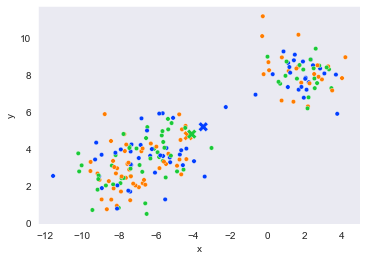

In [13]:
df = df_clusters
k = 3
df_c = initialise_centroids_random_partition(df, k)

plot_df_and_df_c(df, df_c)

Forgy method tends to distribute the centroid starting locations  
Random partition method tends to group centroid starting locations 

In [14]:
#takes points dataframe store and centroid dataframe store
#plots a facetgrid of scatterplots, each plot showing which points belong to which centroid and centroid location
#each plot represents result following an iteration
def plot_centroid_progression(df_store, df_c_store):
           
    #create label to indicate if a row refers to a centroid or a point
    df_store['is_centroid']=False
    df_c_store['is_centroid']=True
    
    #combine points and centroid dataframes
    df_store_combined = df_store.append(df_c_store, ignore_index = True)
    
    #force treatment of centroid no. col as categorical datatype as this improves colour contrast for plotting
    df_store_combined['centroid'] = df_store_combined['centroid'].astype('category')        
    
    #create facet grid to show progression of centroids and assignment
    g = sns.FacetGrid(df_store_combined, col="iteration", col_wrap = 4)
    
    g.map_dataframe(sns.scatterplot, x = 'x', y = 'y', 
                    hue="centroid", style='is_centroid',
                    size='is_centroid', sizes=(100, 20))    
    return g

In [15]:
#takes points dataframe store and centroid dataframe store
#plots a facetgrid of scatterplots, each plot showing which points belong to which centroid and centroid location
#each plot represents result following an iteration
def plot_points_and_centroids_for_k_values(df_k_store, df_c_k_store):
        
    #create label to indicate if a row refers to a centroid or a point
    df_k_store['is_centroid']=False
    df_c_k_store['is_centroid']=True
    
    #combine points and centroid dataframes
    df_k_store_combined = df_k_store.append(df_c_k_store, ignore_index = True)
    
    #force treatment of centroid no. col as categorical datatype as this improves colour contrast for plotting
    df_k_store_combined['centroid'] = df_k_store_combined['centroid'].astype('category')                
    
    #create facet grid to show progression of centroids and assignment
    g = sns.FacetGrid(df_k_store_combined, col="k", col_wrap = 4)
    
    g.map_dataframe(sns.scatterplot, x = 'x', y = 'y', 
                    hue="centroid", style='is_centroid',
                    size='is_centroid', sizes=(100, 20))    
    return g

# K location iteration end conditions

During the iterative process of finding final centroid locations for a set of data points, a given value of k and set of centroid initialisation locations; there are multiple possible means of identifying iteration end conditions. The following functions are implementations of these potential end conditions.

In [16]:
#simple end condition which returns true after completing set number of iterations
def iteration_count(df, df_c, max_number_of_iterations, count, df_store, df_c_store):
    
    if count < max_number_of_iterations:
        return False
    else:
        return True

In [17]:
#end condition which returns true when all data point centroid assignments are constant
#always returns true if count equals or exceeds maximum number of iterations specified
def centroid_assignment_constant(df, df_c, max_number_of_iterations, count, df_store, df_c_store):
    
    #will throw error if we have not already performed at least 1 iteration
    if count > 0:
        
        #create dataframe of previous point centroid assignments from store
        df_previous = df_store[df_store['iteration'] == count-1]
        
        #reset index to match with point dataframe
        df_previous = df_previous.reset_index()
        
        #compare centroid assignments and return true if there is no change
        if df['centroid'].equals(df_previous['centroid']):            
            return True
    
    #implement a fail safe to limit number of iterations 
    #in case the above condition is not met in a reasonable number of iterations
    if count >= max_number_of_iterations:
        print('maximum specified number of iterations reached')
        return True
    
    return False

In [18]:
#end condition which returns true when all centroid positions are constant
def centroid_position_constant(df, df_c, max_number_of_iterations, count, df_store, df_c_store):
    pass

#centroid positions will be constant when all data point centroid assignments are constant
#this means centroids will no longer be pulled in different directions
#there isn't much benefit to implement this condition in addition to the 'centroid_assignment_constant' function

In [19]:
#end condition which returns true when sum of distances between data points and respective centroids is minimised
def point_centroid_squ_distance_minimised(df, df_c, max_number_of_iterations, count, df_store, df_c_store):
    pass

# Finding centroid locations

Implementation of primary function to calculate centroid locations after iteration end conditions are met.

In [20]:
#takes points dataframe and k value
#optional arguments include: centroid initialisation method and iteration end condition
#returns dataframe containing final centroid locations and updates points dataframe with centroid assignments
def main(df, k,
         initialise_centroids_method = initialise_centroids_forgy, #_forgy or _random_partition
         iteration_end_condition = centroid_assignment_constant,
         max_number_of_iterations = 10,         
         plot_progression=False #plots assignment and centroid positions after each iteration
        ):
    
    #initialise centroids for given value of k, as per selected initialisation method
    df_c = initialise_centroids_method(df, k)
    
    #initialise iteration count, point and centroid stores dataframes
    count = 0        
    df['iteration'] = count
    df_c['iteration'] = count
    df_store = df.copy()
    df_c_store = df_c.copy()
    
    #begin iteration looping
    while not iteration_end_condition(df, df_c, max_number_of_iterations, count, df_store, df_c_store):        
        #calculate new centroid positions and re-assign points
        df_c = calculate_centroid_positions(df)        
        df = assign_points_to_nearest_centroid(df, df_c)
        
        #increment iteration count
        count += 1                
        
        #add updated assignment and positions to store dataframes        
        df['iteration'] = count
        df_c['iteration'] = count
        df_store = df_store.append(df, ignore_index = True)    
        df_c_store = df_c_store.append(df_c, ignore_index = True)                    
        
    if plot_progression:
        print(plot_centroid_progression(df_store, df_c_store))        
    
    return df_c

We are able to examine the development of centroid location and data point centroid assignment over the iterative process using the plot_centroid_progression plotting function defined previously.

## Uniform dataset
### Forgy centroid initialisation

In [21]:
df = uniform_df(0, 100, (100, 2))

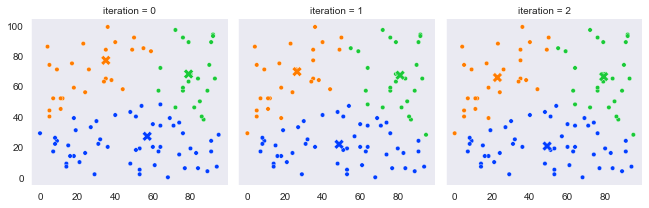

In [22]:
df_c = main(df, 3,
         initialise_centroids_method = initialise_centroids_forgy,
         plot_progression=True,            
           )

## Uniform dataset
### Random partition centroid initialisation

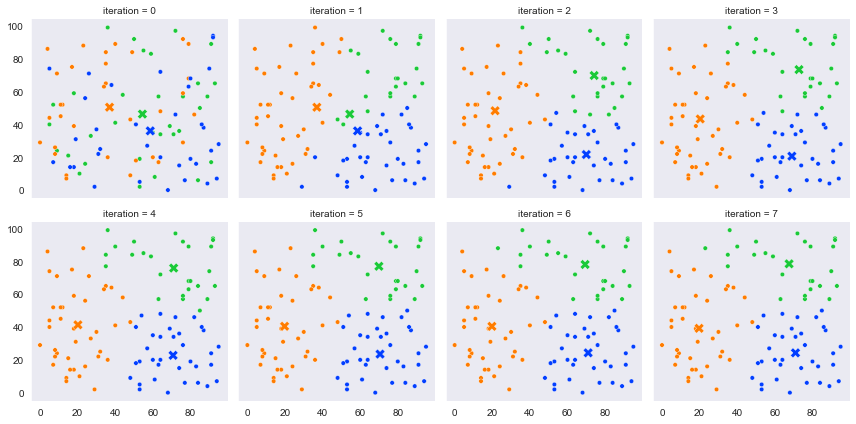

In [23]:
df_c = main(df, 3,
         initialise_centroids_method = initialise_centroids_random_partition,
         plot_progression=True,            
           )

For a more uniform dataset, it is unclear which initialisation method performs better.

## Clusters dataset
### Forgy centroid initialisation

In [39]:
df = clusters_df(100, 3)

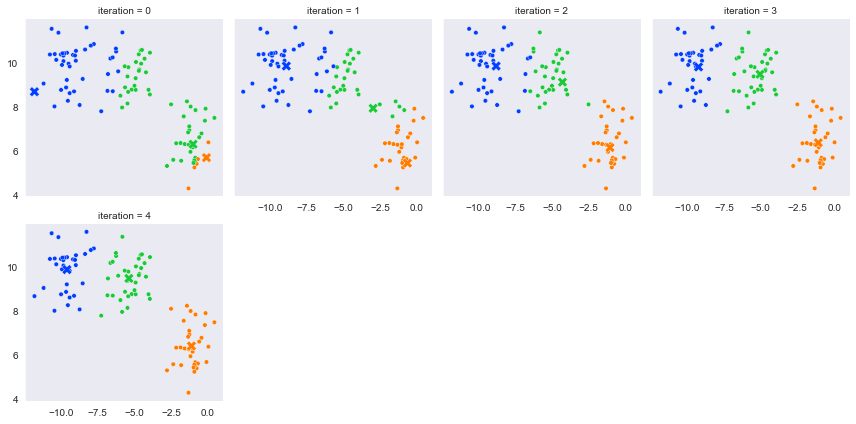

In [40]:
df_c = main(df, 3,
         initialise_centroids_method = initialise_centroids_forgy,
         plot_progression=True,            
           )

## Clusters dataset
### Random partition centroid initialisation

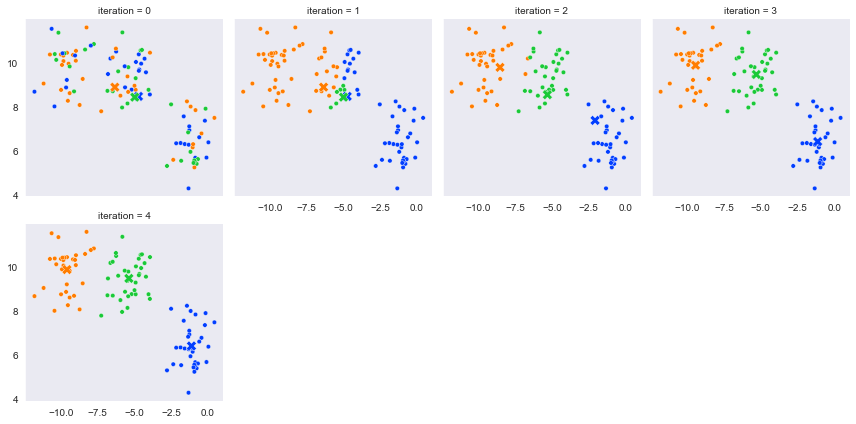

In [41]:
df_c = main(df, 3,
         initialise_centroids_method = initialise_centroids_random_partition,
         plot_progression=True,            
           )

For datasets with more strongly defined clusters, forgy initialisation can result in faster convergence to final centroid locations due to its tendency to spread the starting locations.

# Optimisation and error calculation

For different sets of centroid starting locations, the resulting final centroid locations often vary. As a result there is a need to run multiple trials for a given k value, testing different starting conditions. In order to compare the results we can calculate an error value for each trial.

In this case, the error is defined as the sum of the euclidean square distances between each point and its assigned centroid (once iteration end conditions are reached).

In [27]:
#takes points dataframe with final centroid assignment
#and centroid dataframe with final centroid positions
#returns value of sum of squared distances between all points and their assigned centroids
def calculate_sum_squared_errors(df, df_c):
    
    #create new dataframe from points and centroids
    #for each point, the coordinates of its assigned centroid as added in cols to the right
    df_merged = df.merge(df_c, how='inner', on='centroid', suffixes=('_p', '_c'))
    
    #calculate squared distance from point to centroid for each point (row)
    df_merged['squ_distance'] = df_merged.apply(lambda row:(row['x_p']-row['x_c'])**2 + (row['y_p']-row['y_c'])**2, 
                                                axis=1)
    #add them all together        
    return df_merged['squ_distance'].sum()

## Initialisation optimisation

In [28]:
#takes points dataframe and a given value of k
#runs a set number of trials to find centroid locations for different initialisations
#returns optimum centroid locations and centroid assignments
def initialisation_optimisation(df, k, 
                                trials = 10,
                                initialise_centroids_method = initialise_centroids_forgy,
                                plot_error_variation=False):    
    error_list = []
    
    #begin trials loop
    for n in range(trials):
        #calculate centroid locations for a particular instance of start conditions
        df_c = main(df, k,
                initialise_centroids_method = initialise_centroids_method,
                )
        #calculate error for this trial
        sum_squ_error = calculate_sum_squared_errors(df, df_c)
        
        error_list.append(sum_squ_error)
                        
        #initialise minimum error and optimum value dataframes
        if n == 0:
            min_error = sum_squ_error
            df_c_optimum = df_c.copy()
            df_optimum = df.copy()
        #update minimum error and optimum value dataframes if improved
        elif sum_squ_error < min_error: #and sum_squ_error > 0
            min_error = sum_squ_error
            df_c_optimum = df_c.copy()
            df_optimum = df.copy()
            
    if plot_error_variation:        
        sns.histplot(data=error_list)
            
    return df_c_optimum, min_error, df_optimum

### Variation in error across multiple trials

We can now start to examine the difference in performance of our 2 initialisation conditions with more confidence.

#### Forgy centroid initialisation

In [48]:
df = clusters_df(200, 4)
trials = 30

maximum specified number of iterations reached
maximum specified number of iterations reached
maximum specified number of iterations reached
maximum specified number of iterations reached
Minimum error after 30 trials: 409.401861


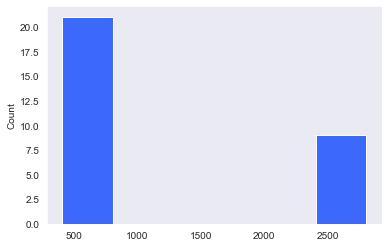

In [49]:
df_c_optimum, min_error, df_optimum = initialisation_optimisation(df, 4, 
                                                                  trials = trials,
                                                                  initialise_centroids_method = initialise_centroids_forgy,
                                                                  plot_error_variation=True)
print('Minimum error after %d trials: %f'%(trials, min_error))

The plot above shows clearly the importance of running multiple trials. Although the error tends to the lower end, for some initialisation condtions larger error values can result.

<AxesSubplot:xlabel='x', ylabel='y'>

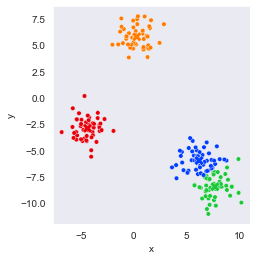

In [50]:
plot_df_and_df_c(df_optimum, df_c_optimum)

#### Random partition centroid initialisation

maximum specified number of iterations reached
Minimum error after 30 trials: 409.401861


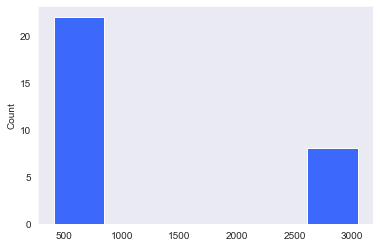

In [51]:
df_c_optimum, min_error, df_optimum = initialisation_optimisation(df, 4, 
                                                                  trials = trials,
                                                                  initialise_centroids_method = initialise_centroids_random_partition,
                                                                  plot_error_variation=True)
print('Minimum error after %d trials: %f'%(trials, min_error))

<AxesSubplot:xlabel='x', ylabel='y'>

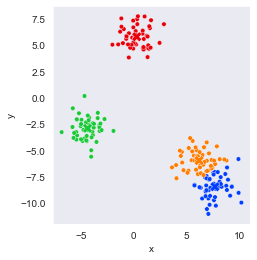

In [52]:
plot_df_and_df_c(df_optimum, df_c_optimum)

This approach allows us to limit the impact of varying initialisation conditions by running multiple trials. We can be reasonably confident that we can now identify the best possible centroid locations for a given k value.

### Forgy - random partition comparison

Both initialisation methods consistently identify the same best final centroid positions and assignments.

I am inclined to prefer the forgy method in this instance. Due to the fact that we are now running multiple trials, we give ourselves the best chance to identify the optimum centroid locations by spreading the starting locations as far as possible. Running multiple trials of a random partition initialisation method should tend to result in less variation in final calculated locations because this initialisation method tends to group starting conditions together.

## K value optimisation - elbow method

The final step in my implementation is to implement a method to identify an optimum k value for a dataset with an unknown number of clusters. We can do this in similar way to how we identified the optimum initialisation conditions. By keeping track of the best error for each value of k we can plot how the error develops as we increase k.

Increasing k should act to reduce the error, as subsequent centroids are added the rate of error improvement should reduce. By identifying the point at which the error improvement rate becomes negligible we can be reasonably confident that we have identified the correct number of clusters present in the data. This is called the elbow method for the apparent elbow in the k-error plot.

In [34]:
#takes a points dataframe and a maximum value of k to investigate
#returns the optimum value of k identified by the algorithm
def k_optimisation(df, k_max,
                  plot_k_trend = False, #plots minimum error for each k value tested
                  plot_cluster_assign = False, #plots best centroid positions and assignments for each k value tested
                  plot_final = False): #plots optimum number of centroids, in best locations with their assigned points
    
    #initialise error dataframe, and points and centroid store dataframes for best trials for each k value tested
    df_error = pd.DataFrame(columns = ['k','error'])
    df_k_store = pd.DataFrame(columns=['x','y','centroid','k'])
    df_c_k_store = pd.DataFrame(columns=['x','y','centroid','k'])    
    
    #begin k testing loop
    for k in range(2,k_max + 1): #assume data must consist of at least 2 clusters
        
        #run optimisation for k value
        df_c_k, min_error, df_k = initialisation_optimisation(df, k, 
                                                              trials = 6,
                                                              plot_error_variation=False)
        #add values to error dataframe
        df_error.loc[len(df_error.index)] = [k, min_error]
                
        #label results with appropriate k value to prepare them for adding to stores
        df_k['k']=k
        df_c_k['k']=k        
        
        #update points and centroid stores with k test results
        df_k_store = df_k_store.append(df_k, ignore_index = True)    
        df_c_k_store = df_c_k_store.append(df_c_k, ignore_index = True)                
    
    #calculate error improvement for each subsequent k value    
    df_error['error_shift'] = df_error['error'].shift(1)
    df_error['improvement_percent'] = df_error.apply(lambda row: (row['error_shift']-row['error'])/row['error_shift']
                                                     , axis=1)
        
    #calculate optimum k value. currently defined as:
    #first value of k for which the addition of a subsequent centroid improves error by less than 20%
    #I chose this arbritarily from looking at the plots, this could certainly be improved/more robust
    #also need to implement a fix in case we never identify an improvement of less than this value
    k_optimum = df_error[(df_error['improvement_percent'] < 0.2)].iloc[0]['k'] - 1 #(df_error['improvement_percent'] > 0) & 
    
    if plot_k_trend: #minimum error trend for all k values
        ax = sns.lineplot(data=df_error, x="k", y="error")
    elif plot_cluster_assign: #best centroid locations and assigned points in a facetgrid for each value of k
        g = plot_points_and_centroids_for_k_values(df_k_store, df_c_k_store)
    elif plot_final: #best df_c and assigned points calculated using optimum k
        pass
                    
    return k_optimum

### Elbow method to identify optimum k value

In [53]:
df = clusters_df(200, 4)

maximum specified number of iterations reached
maximum specified number of iterations reached
maximum specified number of iterations reached
maximum specified number of iterations reached
Best k value: 4.000000


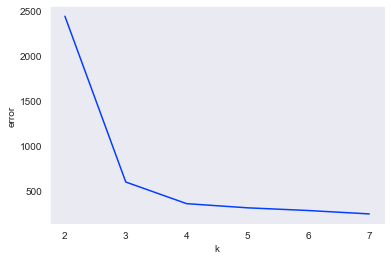

In [54]:
k_max = 7

k_optimum = k_optimisation(df, k_max,
                           plot_k_trend = True,
                           plot_cluster_assign = False,
                           )

print('Best k value: %f'%(k_optimum))

We can plot the same data points and the optimal centroid locations identified for each k value tested to demonstrate why the error value drops as shown in the elbow plot.

maximum specified number of iterations reached
maximum specified number of iterations reached
maximum specified number of iterations reached
Best k value: 4.000000


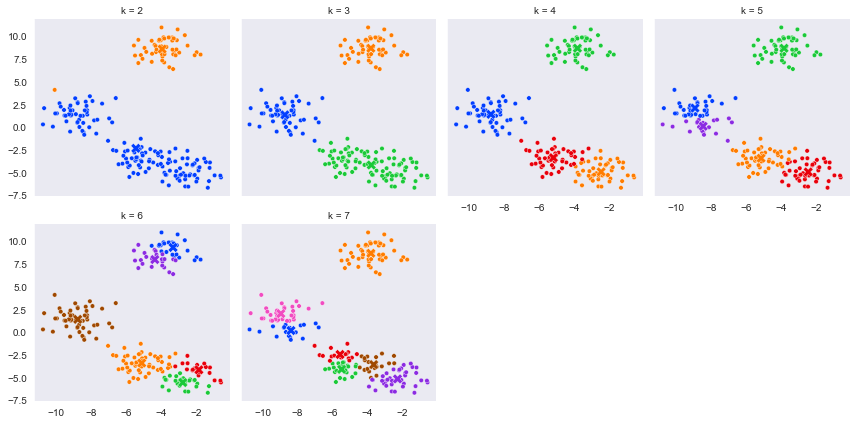

In [55]:
k_optimum = k_optimisation(df, 7,
                           plot_k_trend = False,
                           plot_cluster_assign = True,
                           )

print('Best k value: %f'%(k_optimum))

Once each cluster has been identified individually, addition of subsequent centroids splits existing clusters in half and results in only a marginal improvement on the total error.

# Result

This final grid plot demonstrates well the process of identification of cluster centres.

This implementation of k-means clustering, in particular using euclidean square distances as the error measurement, will always tend to identify clusters as regularly sized clouds of points arranged within the bounds of a circle around the centroid. For other datasets this approach could easily have issues.

In addition, for the larger numbers of clusters tested the algorithm can start to have problems where by less than the number of specified number of clusters are identified as the optimum result. This can be as a result of clusters lying close together or overlapping.

My current implementation of the elbow method for k-optimisation uses an error improvement rate threshold value which was defined through trial and error, this could certainly have issues when faced with more varied datasets.

## Final thoughts

Overall, it is very satisfying to see how effective the algorithm can be.

Once I had an implementation of the basic algorithm, there was considerable functionality that could be added in small pieces to develop my understanding. This made the project addictive and I have enjoyed building it to this stage. There remain many areas that could be further developed to increase functionality.

There is no doubt that this could be implemented much more efficiently, however as a proof of concept and educational exercise I am extremely happy with the result.

Ultimately I have learnt a significant amount about k-means clustering. I am also particularly pleased with how much more comfortable I feel using python and the pandas library in particular following this exercise.

# Further work/ideas

###### Initialisation
* Further investigate forgy and random partition comparison;
* In what use cases would one be ideally selected other the other
* What other methods exist?

##### Functionality
* Implement normalisation of dataset before processing
* Add multi-dimensional functionality

##### K-value optimisation
* Elbow method; improve method of identification of elbow point
* Implement a silhouette analysis method

###### Efficiency
* Improve algorithm efficiency, particular for use with larger datasets

##### Evaluation
* Test on a variety of real world datasets
* Comparison of results to a scikit-learn implementation